In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coordinated-attack-dataset-for-cids-nf/CoAt_NF-UQ-NIDS-V2.parquet


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load dataset
df = pd.read_parquet('/kaggle/input/coordinated-attack-dataset-for-cids-nf/CoAt_NF-UQ-NIDS-V2.parquet', engine='pyarrow')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

In [5]:
# Encode labels numerically
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

In [6]:
# Get the list of unique classes
unique_classes = label_encoder.classes_
num_classes = len(unique_classes)

In [7]:
# Separate features and target
y = df['Label'].values
df = df.drop(['Label', 'Attack'], axis=1).values

In [8]:
# Split the dataset
df, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
# Standardize the data
scaler = QuantileTransformer(output_distribution='normal')
df = scaler.fit_transform(df)
X_test = scaler.transform(X_test)

In [10]:
# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
# Build the neural network for multiclass classification
model = Sequential([
    Dense(64, input_dim=df.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Train the model
history = model.fit(df, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1180s 2ms/step - accuracy: 0.9610 - loss: 0.1119 - val_accuracy: 0.9630 - val_loss: 0.1098
Epoch 2/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1170s 2ms/step - accuracy: 0.9696 - loss: 0.0873 - val_accuracy: 0.9700 - val_loss: 0.1068
Epoch 3/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1177s 2ms/step - accuracy: 0.9702 - loss: 0.0863 - val_accuracy: 0.9730 - val_loss: 0.0892
Epoch 4/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1205s 2ms/step - accuracy: 0.9713 - loss: 0.0840 - val_accuracy: 0.9689 - val_loss: 0.1105
Epoch 5/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1199s 2ms/step - accuracy: 0.9718 - loss: 0.0831 - val_accuracy: 0.9355 - val_loss: 0.1246
Epoch 6/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1221s 2ms/step - accuracy: 0.9719 - loss: 0.0830 - val_accuracy: 0.9351 - val_loss: 0.1136
Epoch 7/10
763641/763641 ━━━━━━━━━━━━━━━━━━━━ 1221s 2ms/step - accuracy: 0.9719 - loss: 0.0834 - val_accuracy: 0.9729 - val_loss: 0.1083
Epoch 8/10
763641/763641 ━━━━━━━━━━━━━━━━

In [13]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode the predicted labels back to the original class labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Classification report
print(classification_report(y_test_decoded, y_pred_decoded, target_names=unique_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
print("Confusion Matrix:")
print(conf_matrix)

409094/409094 ━━━━━━━━━━━━━━━━━━━━ 447s 1ms/step
              precision    recall  f1-score   support

      Benign       0.94      0.97      0.96   6223147
        DDoS       1.00      0.99      1.00   5190861
        Scan       0.86      0.81      0.83   1619332
        Worm       0.98      0.31      0.48     57640

    accuracy                           0.96  13090980
   macro avg       0.94      0.77      0.81  13090980
weighted avg       0.95      0.96      0.95  13090980

Confusion Matrix:
[[6028275    2282  192233     357]
 [  23221 5151594   16046       0]
 [ 307321    7114 1304863      34]
 [  31616       6    7900   18118]]


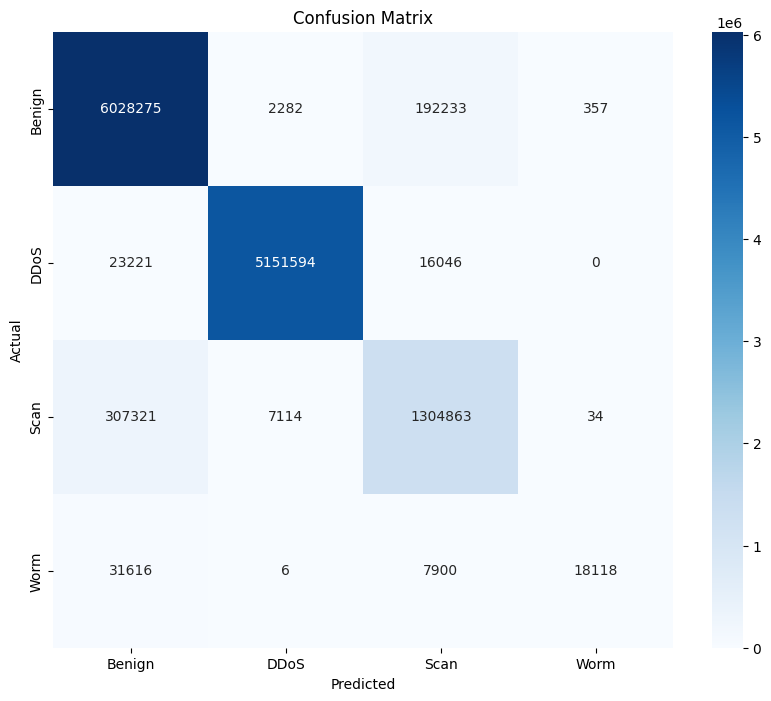

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

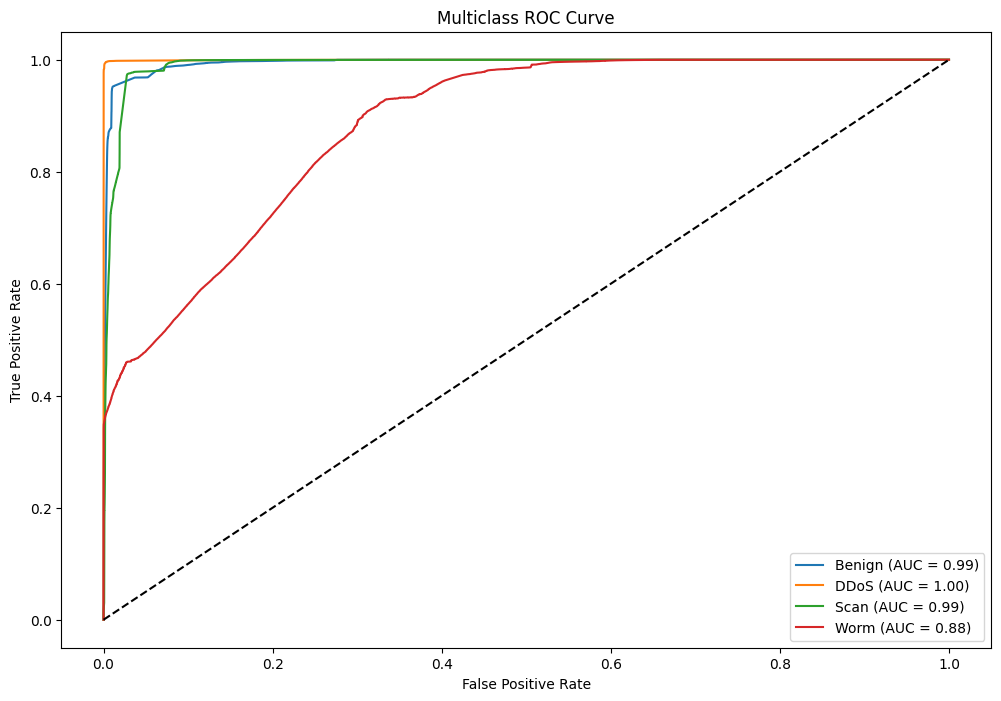

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(unique_classes):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

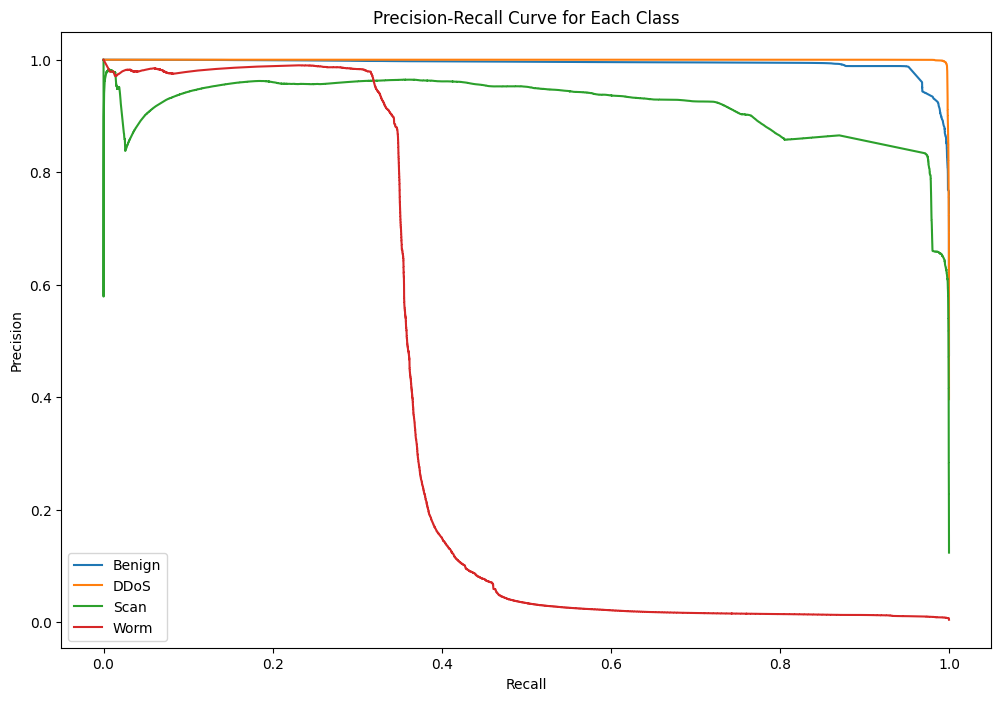

In [16]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(unique_classes):
    precision, recall, _ = precision_recall_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()